In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
import torch.optim as optim
from nn_base_models import FeedforwardNN

Epoch 0: Loss = 4.380327e+03
Epoch 500: Loss = 6.881438e+02
Epoch 1000: Loss = 3.531621e+01
Epoch 1500: Loss = 2.172478e+01
Epoch 2000: Loss = 8.558154e+00
Epoch 2500: Loss = 4.866549e+00


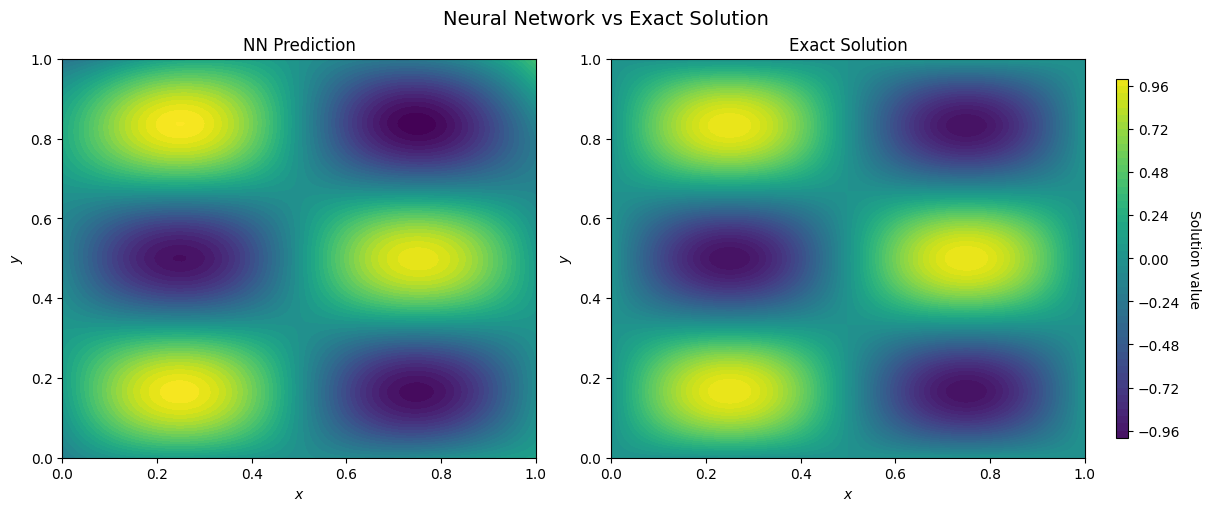

In [10]:
# Forcing function: f(x, y) = 13pi^2 sin(2pix) sin(3piy)
def f_rhs(x, y):
    return 13 * np.pi**2 * torch.sin(2 * np.pi * x) * torch.sin(3 * np.pi * y)

# Function to sample points in the interior and on the boundary
def sample_points(n_interior=1000, n_boundary=200):
    # Interior: random points in (0,1)×(0,1)
    x_interior = torch.rand((n_interior, 2), dtype=torch.float32)

    # Boundary: concatenate edges of square
    edge = torch.linspace(0, 1, n_boundary // 4)
    xb = torch.cat([
        torch.stack([edge, torch.zeros_like(edge)], dim=1),
        torch.stack([edge, torch.ones_like(edge)], dim=1),
        torch.stack([torch.zeros_like(edge), edge], dim=1),
        torch.stack([torch.ones_like(edge), edge], dim=1)
    ])
    return x_interior, xb

# Loss function
def poisson_loss(model, x_interior, x_boundary, gamma=100.0):
    x_interior.requires_grad_(True)
    u = model(x_interior)

    # Compute Laplacian using autograd
    grad_u = torch.autograd.grad(u, x_interior, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    du_dx, du_dy = grad_u[:, 0:1], grad_u[:, 1:2]
    d2u_dx2 = torch.autograd.grad(du_dx, x_interior, grad_outputs=torch.ones_like(du_dx), create_graph=True)[0][:, 0:1]
    d2u_dy2 = torch.autograd.grad(du_dy, x_interior, grad_outputs=torch.ones_like(du_dy), create_graph=True)[0][:, 1:2]
    lap_u = d2u_dx2 + d2u_dy2

    # PDE residual
    f_vals = f_rhs(x_interior[:, 0:1], x_interior[:, 1:2])
    loss_pde = torch.mean((lap_u + f_vals)**2)

    # Boundary loss
    u_boundary = model(x_boundary)
    loss_bc = torch.mean(u_boundary**2)

    return loss_pde + gamma * loss_bc

# Model training function
def train_poisson(model, epochs=3000, lr=1e-3, gamma=100.0, verbose=True):
    x_int, x_bd = sample_points()
    optimiser = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        optimiser.zero_grad()
        loss = poisson_loss(model, x_int, x_bd, gamma)
        loss.backward()
        optimiser.step()

        if verbose and epoch % 500 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.6e}")


# Sensecheck the model has worked
model = FeedforwardNN(input_dim=2, output_dim=1, hidden_layers=3, hidden_units=30, activation='swish')
train_poisson(model, epochs=3000, lr=1e-3, gamma=100.0)

x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
xy = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=-1), dtype=torch.float32)

with torch.no_grad():
    u_pred = model(xy).view(100, 100).numpy()

u_true = np.sin(2 * np.pi * X) * np.sin(3 * np.pi * Y)

# Ensure they're ont the same scale
# Compute global color limits
vmin = min(u_pred.min(), u_true.min())
vmax = max(u_pred.max(), u_true.max())

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Plot NN prediction
cf1 = axes[0].contourf(X, Y, u_pred, levels=50, cmap='viridis', vmin=vmin, vmax=vmax)
axes[0].set_title("NN Prediction")
axes[0].set_xlabel("$x$")
axes[0].set_ylabel("$y$")

# Plot exact solution
cf2 = axes[1].contourf(X, Y, u_true, levels=50, cmap='viridis', vmin=vmin, vmax=vmax)
axes[1].set_title("Exact Solution")
axes[1].set_xlabel("$x$")
axes[1].set_ylabel("$y$")

# Add single shared colorbar
cbar = fig.colorbar(cf2, ax=axes, orientation='vertical', shrink=0.9, aspect=30, pad=0.02)
cbar.set_label("Solution value", rotation=270, labelpad=15)

plt.suptitle("Neural Network vs Exact Solution", fontsize=14)
plt.show()


AttributeError: module 'matplotlib.pyplot' has no attribute 'save_fig'

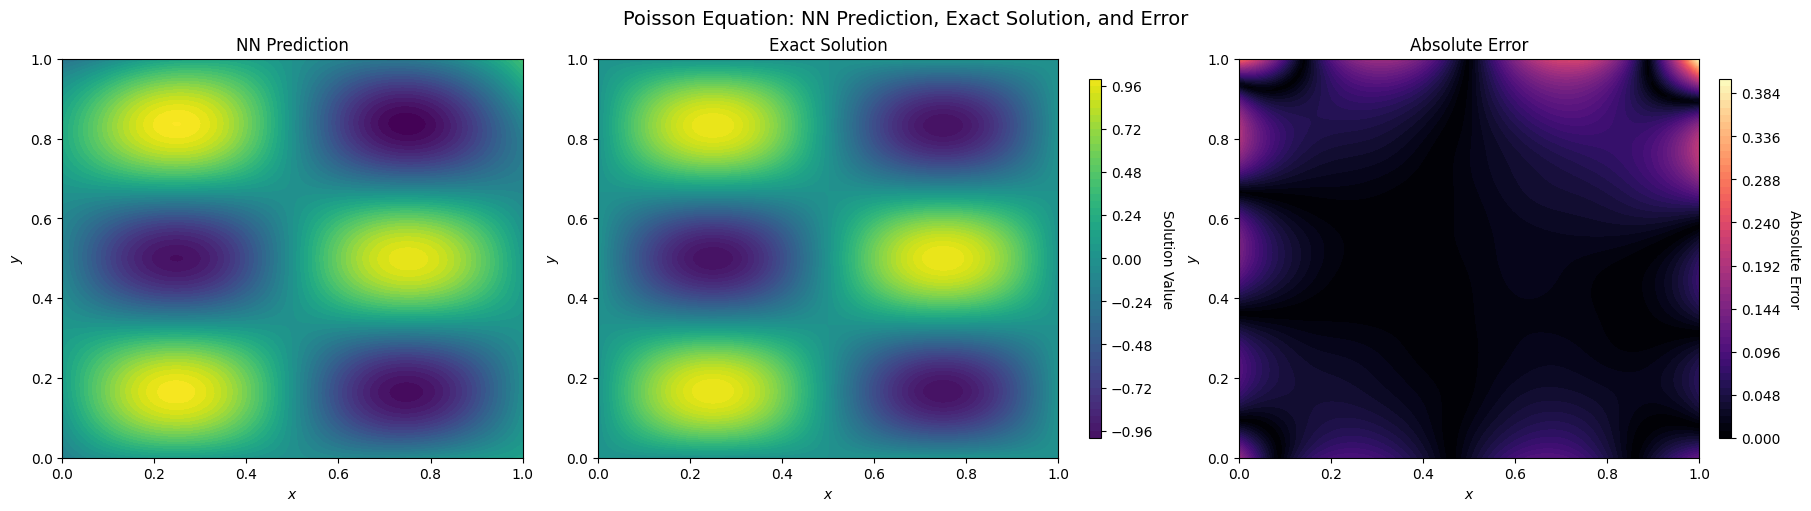

In [ ]:
# Compute values
vmin = min(u_pred.min(), u_true.min())
vmax = max(u_pred.max(), u_true.max())
error = np.abs(u_pred - u_true)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

# NN Prediction
cf1 = axes[0].contourf(X, Y, u_pred, levels=50, cmap='viridis', vmin=vmin, vmax=vmax)
axes[0].set_title("NN Prediction")
axes[0].set_xlabel("$x$")
axes[0].set_ylabel("$y$")

# Exact Solution
cf2 = axes[1].contourf(X, Y, u_true, levels=50, cmap='viridis', vmin=vmin, vmax=vmax)
axes[1].set_title("Exact Solution")
axes[1].set_xlabel("$x$")
axes[1].set_ylabel("$y$")

# Absolute Error
cf3 = axes[2].contourf(X, Y, error, levels=50, cmap='magma')
axes[2].set_title("Absolute Error")
axes[2].set_xlabel("$x$")
axes[2].set_ylabel("$y$")

# Shared colorbar for NN + Exact
cbar = fig.colorbar(cf2, ax=axes[:2], orientation='vertical', shrink=0.9, aspect=30, pad=0.02)
cbar.set_label("Solution Value", rotation=270, labelpad=15)

# Separate colorbar for error
cbar_err = fig.colorbar(cf3, ax=axes[2], orientation='vertical', shrink=0.9, aspect=30, pad=0.02)
cbar_err.set_label("Absolute Error", rotation=270, labelpad=15)

plt.suptitle("Poisson Equation: NN Prediction, Exact Solution, and Error", fontsize=14)
plt.savefig("report/graphics/PDE_first_example")
plt.show()

In [6]:
# generate results for nn's of different depth and width and with the ReLu vs Tanh activation functions

activations = ['tanh', 'relu']
layer_counts = list(range(1, 11))    # 1 to 5 hidden layers
widths = list(range(1, 22))      # 5, 10, 15, 20, 25 neurons

results = []

for act in activations:
    for layers in layer_counts:
        for width in widths:
            print(f"Training: activation={act}, layers={layers}, width={width}")
            model = FeedforwardNN(input_dim=2, output_dim=1,
                                  hidden_layers=layers,
                                  hidden_units=width,
                                  activation=act)
            start_time = time.time()
            train_poisson(model, epochs=1500, lr=1e-3, gamma=100.0, verbose=False)
            duration = time.time() - start_time

            # Evaluate on uniform 2D grid
            x = np.linspace(0, 1, 100)
            y = np.linspace(0, 1, 100)
            X, Y = np.meshgrid(x, y)
            xy_test = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=-1), dtype=torch.float32)

            with torch.no_grad():
                u_pred = model(xy_test).view(100, 100).numpy()
            u_true = np.sin(2 * np.pi * X) * np.sin(3 * np.pi * Y)
            mse = np.mean((u_pred - u_true) ** 2)

            results.append({
                "activation": act,
                "layers": layers,
                "width": width,
                "mse": mse,
                "train_time_sec": duration
            })

# Save to CSV
results_df = pd.DataFrame(results)
results_df.to_csv("Data/PDE_data/poisson_2D_results.csv", index=False)

Training: activation=tanh, layers=1, width=1
Training: activation=tanh, layers=1, width=2
Training: activation=tanh, layers=1, width=3
Training: activation=tanh, layers=1, width=4
Training: activation=tanh, layers=1, width=5
Training: activation=tanh, layers=1, width=6
Training: activation=tanh, layers=1, width=7
Training: activation=tanh, layers=1, width=8
Training: activation=tanh, layers=1, width=9
Training: activation=tanh, layers=1, width=10
Training: activation=tanh, layers=1, width=11
Training: activation=tanh, layers=1, width=12
Training: activation=tanh, layers=1, width=13
Training: activation=tanh, layers=1, width=14
Training: activation=tanh, layers=1, width=15
Training: activation=tanh, layers=1, width=16
Training: activation=tanh, layers=1, width=17
Training: activation=tanh, layers=1, width=18
Training: activation=tanh, layers=1, width=19
Training: activation=tanh, layers=1, width=20
Training: activation=tanh, layers=1, width=21
Training: activation=tanh, layers=2, width=

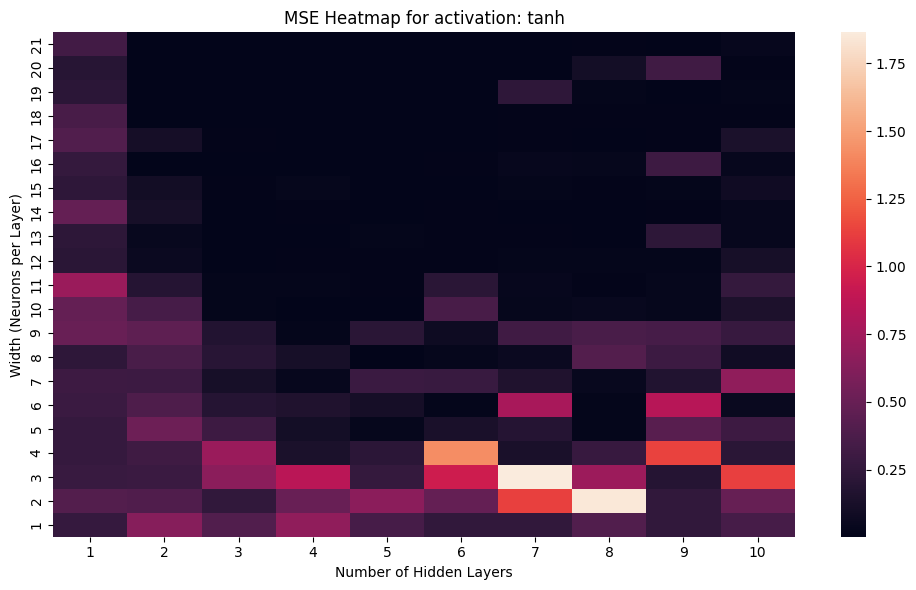

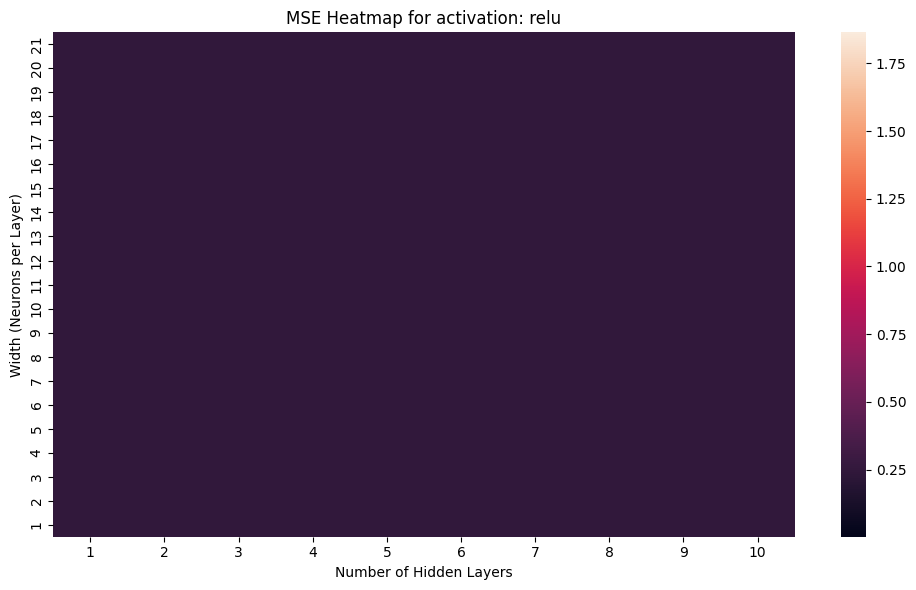

In [7]:
# Ensure the heatmaps use the same scale
global_min = results_df["mse"].min()
global_max = results_df["mse"].max()
log_norm = mcolors.Normalize(vmin=global_min, vmax=global_max)

results_df = pd.DataFrame(results)
for act in results_df['activation'].unique():
    df_subset = results_df[results_df['activation'] == act]

    plt.figure(figsize=(10, 6))
    heatmap_data = df_subset.pivot(index="width", columns="layers", values="mse")
    sns.heatmap(heatmap_data, cmap="rocket", norm=log_norm)
    plt.gca().invert_yaxis()
    plt.title(f"MSE Heatmap for activation: {act}")
    plt.xlabel("Number of Hidden Layers")
    plt.ylabel("Width (Neurons per Layer)")
    plt.tight_layout()
    plt.savefig(f"report/graphics/mse_heatmap_pde_poisson_{act}.png", dpi=300)
    plt.show()

Retraining: activation=tanh, layers=2, width=21


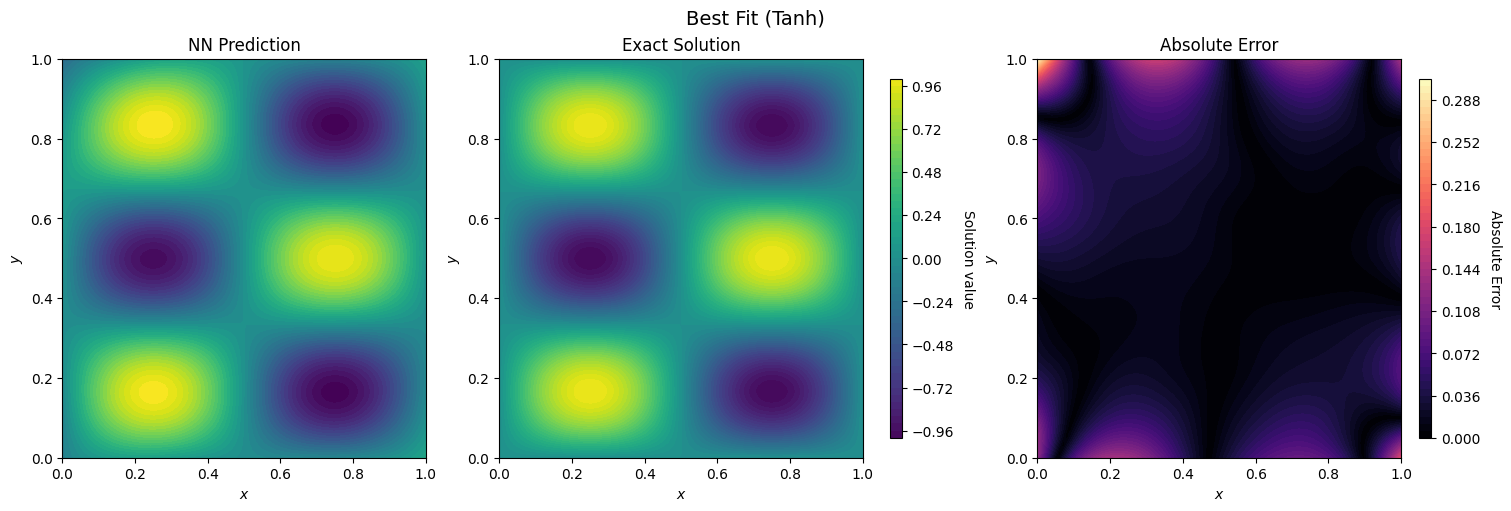

Retraining: activation=tanh, layers=7, width=3


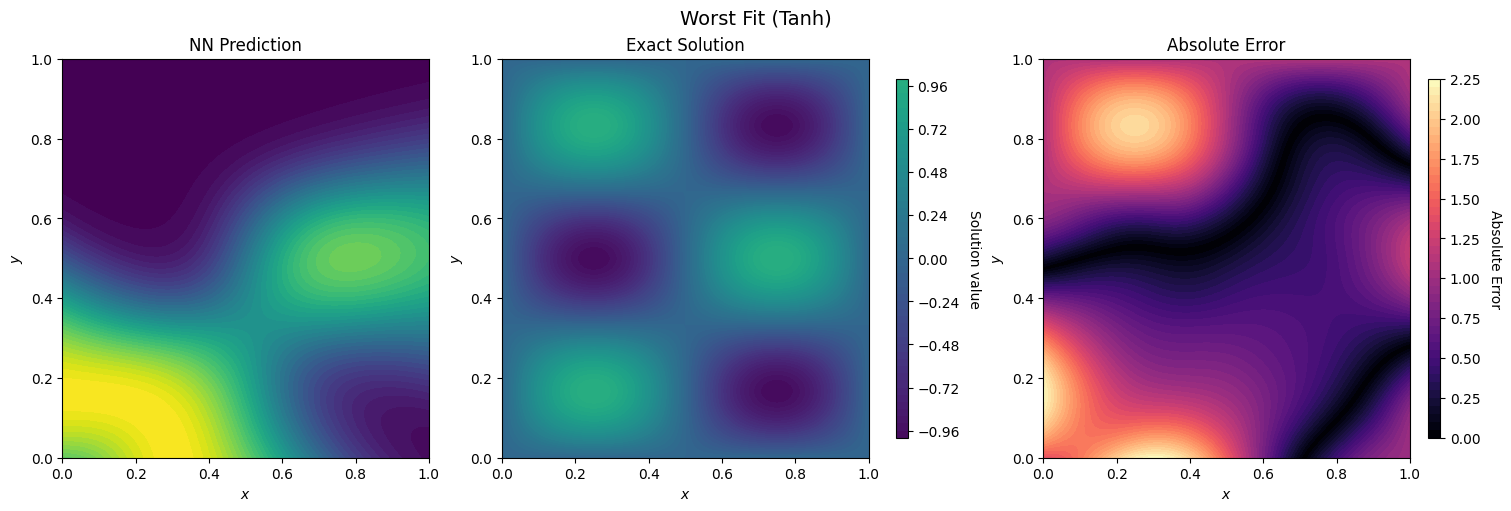

Retraining: activation=relu, layers=1, width=3


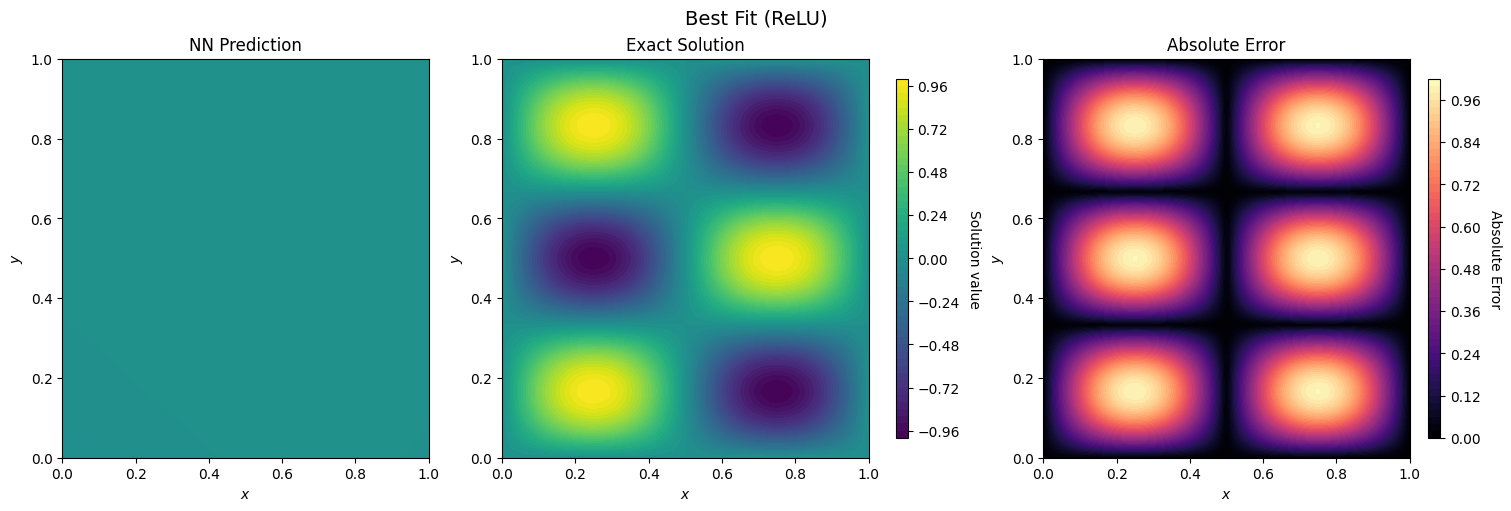

Retraining: activation=relu, layers=6, width=1


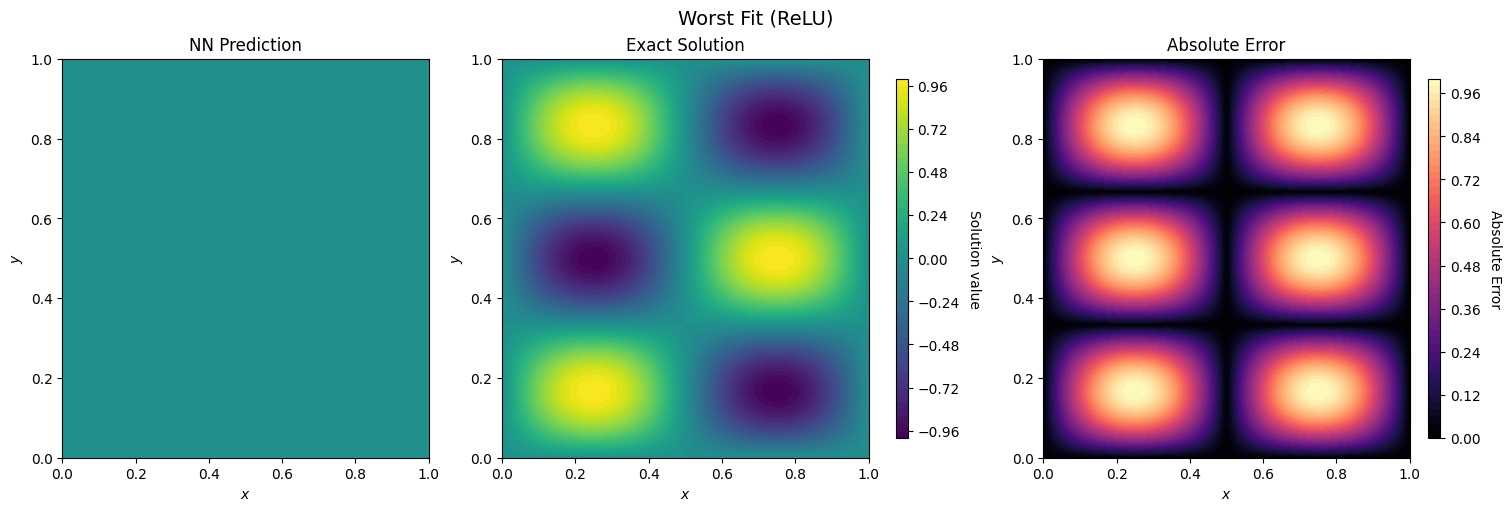

In [12]:
results_df = pd.read_csv("Data/PDE_data/poisson_2D_results.csv")


best_configs = {}
worst_configs = {}

for act in results_df['activation'].unique():
    df_sub = results_df[results_df['activation'] == act]
    best_configs[act] = df_sub.loc[df_sub['mse'].idxmin()]
    worst_configs[act] = df_sub.loc[df_sub['mse'].idxmax()]

def plot_poisson_fit(config, title, save_prefix="fit_plot"):
    layers = int(config['layers'])
    width = int(config['width'])
    act = config['activation']

    print(f"Retraining: activation={act}, layers={layers}, width={width}")
    model = FeedforwardNN(input_dim=2, output_dim=1,
                          hidden_layers=layers,
                          hidden_units=width,
                          activation=act)

    train_poisson(model, epochs=3000, lr=1e-3, gamma=100.0, verbose=False)

    # Prepare test grid
    x = np.linspace(0, 1, 100)
    y = np.linspace(0, 1, 100)
    X, Y = np.meshgrid(x, y)
    xy = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=-1), dtype=torch.float32)

    with torch.no_grad():
        u_pred = model(xy).view(100, 100).numpy()

    u_true = np.sin(2 * np.pi * X) * np.sin(3 * np.pi * Y)
    error = np.abs(u_pred - u_true)

    vmin = min(u_pred.min(), u_true.min())
    vmax = max(u_pred.max(), u_true.max())

    fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

    cf1 = axes[0].contourf(X, Y, u_pred, levels=50, cmap='viridis', vmin=vmin, vmax=vmax)
    axes[0].set_title("NN Prediction")

    cf2 = axes[1].contourf(X, Y, u_true, levels=50, cmap='viridis', vmin=vmin, vmax=vmax)
    axes[1].set_title("Exact Solution")

    cf3 = axes[2].contourf(X, Y, error, levels=50, cmap='magma')
    axes[2].set_title("Absolute Error")

    for ax in axes:
        ax.set_xlabel("$x$")
        ax.set_ylabel("$y$")

    cbar1 = fig.colorbar(cf2, ax=axes[:2], orientation='vertical', shrink=0.9, aspect=30, pad=0.02)
    cbar1.set_label("Solution value", rotation=270, labelpad=15)

    cbar2 = fig.colorbar(cf3, ax=axes[2], orientation='vertical', shrink=0.9, aspect=30, pad=0.02)
    cbar2.set_label("Absolute Error", rotation=270, labelpad=15)

    plt.suptitle(title, fontsize=14)
    filename = f"report/graphics/pde_poisson_{save_prefix}_{act}_{layers}layers_{width}width.png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

# Call plotting function
plot_poisson_fit(best_configs["tanh"], "Best Fit (Tanh)", save_prefix="best_fit")
plot_poisson_fit(worst_configs["tanh"], "Worst Fit (Tanh)", save_prefix="worst_fit")
plot_poisson_fit(best_configs["relu"], "Best Fit (ReLU)", save_prefix="best_fit")
plot_poisson_fit(worst_configs["relu"], "Worst Fit (ReLU)", save_prefix="worst_fit")